In [1]:
!pip install feature-engine

^C


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.missing_data_imputers import CategoricalVariableImputer, FrequentCategoryImputer
from feature_engine.missing_data_imputers import AddNaNBinaryImputer
import xgboost as xgb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
train = pd.read_csv(r'''C:\Users\Sandeep's\Desktop\Competitive Data Science\Analytics Vidhya\JantaHack_Mobility_Analytics\Data\train_Wc8LBpr.csv''')
test = pd.read_csv(r'''C:\Users\Sandeep's\Desktop\Competitive Data Science\Analytics Vidhya\JantaHack_Mobility_Analytics\Data\test_VsU9xXK.csv''')
ss = pd.read_csv(r'''C:\Users\Sandeep's\Desktop\Competitive Data Science\Analytics Vidhya\JantaHack_Mobility_Analytics\Data\sample_submission_NoPBkjr.csv''')

In [8]:
train.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [9]:
test.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender
0,T0005689459,9.44,A,10.0,2.57438,A,B,3.68000,2,NaN,46,63,Male
1,T0005689462,32.15,B,10.0,2.85143,A,A,1.59375,0,65.0,49,80,Female
2,T0005689463,10.38,C,4.0,2.70530,A,D,4.50500,0,NaN,47,74,Male
3,T0005689466,14.94,NaN,6.0,2.48159,C,E,4.53000,0,63.0,43,54,Male
4,T0005689468,32.03,B,7.0,2.81598,A,K,4.60125,3,96.0,44,56,Male


In [10]:
ss.head()

,Trip_ID,Surge_Pricing_Type
0,T0005689459,2
1,T0005689462,2
2,T0005689463,2
3,T0005689466,2
4,T0005689468,2


In [11]:
print("train dataset is of shape: ", train.shape)
print("test dataset is of shape: ", test.shape)

train dataset is of shape:  (131662, 14)
test dataset is of shape:  (87395, 13)


In [12]:
train.isnull().sum()

Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                    20210
Customer_Since_Months           5920
Life_Style_Index               20193
Confidence_Life_Style_Index    20193
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           71030
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

In [13]:
test.isnull().sum()

Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                    13158
Customer_Since_Months           3966
Life_Style_Index               13327
Confidence_Life_Style_Index    13327
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           46789
Var2                               0
Var3                               0
Gender                             0
dtype: int64

# Data Exploration

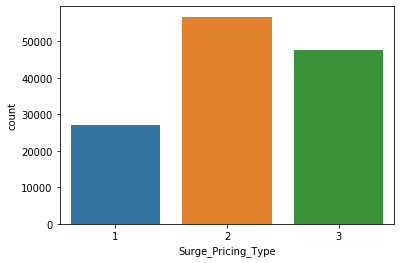

In [15]:
sns.countplot(train['Surge_Pricing_Type'])

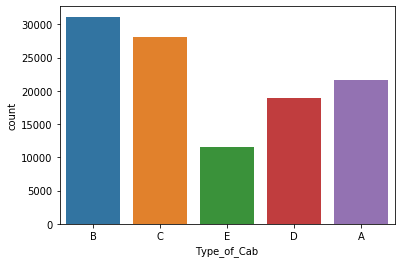

In [16]:
sns.countplot(train["Type_of_Cab"])

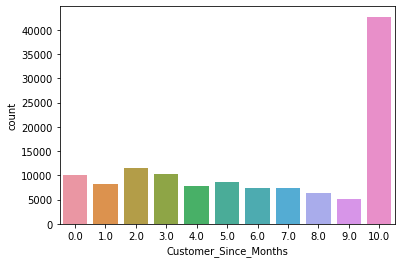

In [17]:
sns.countplot(train["Customer_Since_Months"])

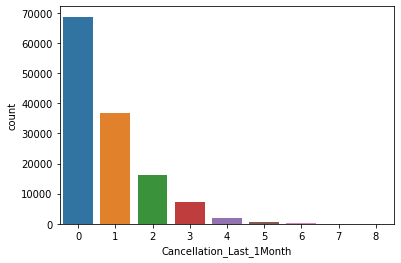

In [18]:
sns.countplot(train["Cancellation_Last_1Month"])

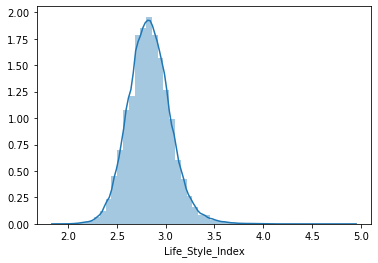

In [21]:
sns.distplot(train.dropna()["Life_Style_Index"])

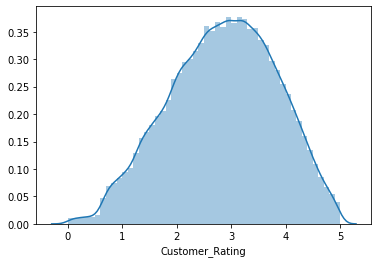

In [22]:
sns.distplot(train["Customer_Rating"])

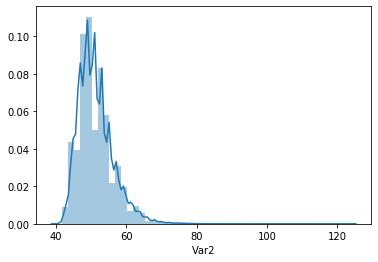

In [24]:
sns.distplot(train["Var2"])

You can see few categories are present dominantly. Distribution of the real values are almost normal distribution but with a shift

# XGB Basemodel with little FE

In [25]:
X = train.drop(['Trip_ID','Surge_Pricing_Type'],axis=1)
y = train['Surge_Pricing_Type']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=43,
                                                        stratify = y,test_size=0.2)

In [42]:
miss_ind = AddNaNBinaryImputer()
miss_ind.fit(X_train)
X_train_pre = miss_ind.transform(X_train)
X_val_pre = miss_ind.transform(X_val)
test_pre = miss_ind.transform(test.drop('Trip_ID',axis=1))


impu = FrequentCategoryImputer(variables = ['Type_of_Cab','Confidence_Life_Style_Index'])
impu.fit(X_train_pre)
X_train_pre = impu.transform(X_train_pre)
X_val_pre = impu.transform(X_val_pre)
test_pre = impu.transform(test_pre)


obj_cols = ['Type_of_Cab','Confidence_Life_Style_Index','Destination_Type','Gender']
ohe = OneHotCategoricalEncoder(variables=obj_cols,drop_last=True)
ohe.fit(X_train_pre)

X_train_pre = ohe.transform(X_train_pre)
X_val_pre = ohe.transform(X_val_pre)
test_pre = ohe.transform(test_pre)

c:\users\sandeep's\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


In [43]:
dtrain = xgb.DMatrix(X_train_pre, (y_train-1))
deval = xgb.DMatrix(X_val_pre, (y_val-1))
watchlist = [(deval, 'eval')]
params = {
    'booster': 'gbtree',
    'num_class':3,
    'objective': 'multi:softprob',
    'colsample_bytree': 0.8,
    'eta': 0.1,
    'max_depth': 3,
    'seed': 2017,
    'silent': 1,
   # 'gamma':0.005,
    'subsample':0.8,
    'eval_metric': 'mlogloss'
}

clf = xgb.train(params, dtrain, 5000, watchlist, early_stopping_rounds=100)

[0]	eval-mlogloss:1.07502
Will train until eval-mlogloss hasn't improved in 100 rounds.
[1]	eval-mlogloss:1.03837
[2]	eval-mlogloss:1.00618
[3]	eval-mlogloss:0.975521
[4]	eval-mlogloss:0.95055
[5]	eval-mlogloss:0.93019
[6]	eval-mlogloss:0.913434
[7]	eval-mlogloss:0.896337
[8]	eval-mlogloss:0.884117
[9]	eval-mlogloss:0.872556
[10]	eval-mlogloss:0.861266
[11]	eval-mlogloss:0.852268
[12]	eval-mlogloss:0.845072
[13]	eval-mlogloss:0.838321
[14]	eval-mlogloss:0.829422
[15]	eval-mlogloss:0.822083
[16]	eval-mlogloss:0.81546
[17]	eval-mlogloss:0.809543
[18]	eval-mlogloss:0.805068
[19]	eval-mlogloss:0.801041
[20]	eval-mlogloss:0.796341
[21]	eval-mlogloss:0.791003
[22]	eval-mlogloss:0.78661
[23]	eval-mlogloss:0.783628
[24]	eval-mlogloss:0.780361
[25]	eval-mlogloss:0.77806
[26]	eval-mlogloss:0.775373
[27]	eval-mlogloss:0.772715
[28]	eval-mlogloss:0.770377
[29]	eval-mlogloss:0.768685
[30]	eval-mlogloss:0.766669
[31]	eval-mlogloss:0.764902
[32]	eval-mlogloss:0.762989
[33]	eval-mlogloss:0.761382
[34]

[286]	eval-mlogloss:0.70303
[287]	eval-mlogloss:0.703012
[288]	eval-mlogloss:0.702963
[289]	eval-mlogloss:0.702927
[290]	eval-mlogloss:0.702892
[291]	eval-mlogloss:0.702879
[292]	eval-mlogloss:0.702868
[293]	eval-mlogloss:0.702856
[294]	eval-mlogloss:0.702808
[295]	eval-mlogloss:0.702778
[296]	eval-mlogloss:0.702726
[297]	eval-mlogloss:0.702724
[298]	eval-mlogloss:0.702692
[299]	eval-mlogloss:0.702649
[300]	eval-mlogloss:0.702634
[301]	eval-mlogloss:0.702612
[302]	eval-mlogloss:0.70261
[303]	eval-mlogloss:0.702573
[304]	eval-mlogloss:0.702551
[305]	eval-mlogloss:0.702516
[306]	eval-mlogloss:0.702472
[307]	eval-mlogloss:0.702409
[308]	eval-mlogloss:0.702401
[309]	eval-mlogloss:0.702371
[310]	eval-mlogloss:0.702369
[311]	eval-mlogloss:0.702358
[312]	eval-mlogloss:0.702342
[313]	eval-mlogloss:0.702315
[314]	eval-mlogloss:0.702298
[315]	eval-mlogloss:0.70229
[316]	eval-mlogloss:0.702279
[317]	eval-mlogloss:0.702228
[318]	eval-mlogloss:0.702186
[319]	eval-mlogloss:0.702174
[320]	eval-mloglo

[570]	eval-mlogloss:0.699649
[571]	eval-mlogloss:0.69964
[572]	eval-mlogloss:0.699625
[573]	eval-mlogloss:0.699629
[574]	eval-mlogloss:0.699647
[575]	eval-mlogloss:0.699657
[576]	eval-mlogloss:0.699674
[577]	eval-mlogloss:0.699678
[578]	eval-mlogloss:0.699688
[579]	eval-mlogloss:0.699708
[580]	eval-mlogloss:0.699709
[581]	eval-mlogloss:0.6997
[582]	eval-mlogloss:0.699699
[583]	eval-mlogloss:0.699694
[584]	eval-mlogloss:0.699691
[585]	eval-mlogloss:0.699692
[586]	eval-mlogloss:0.699677
[587]	eval-mlogloss:0.699691
[588]	eval-mlogloss:0.699676
[589]	eval-mlogloss:0.699694
[590]	eval-mlogloss:0.699682
[591]	eval-mlogloss:0.699698
[592]	eval-mlogloss:0.699685
[593]	eval-mlogloss:0.699683
[594]	eval-mlogloss:0.69968
[595]	eval-mlogloss:0.699702
[596]	eval-mlogloss:0.6997
[597]	eval-mlogloss:0.699699
[598]	eval-mlogloss:0.699702
[599]	eval-mlogloss:0.699688
[600]	eval-mlogloss:0.699687
[601]	eval-mlogloss:0.699669
[602]	eval-mlogloss:0.699669
[603]	eval-mlogloss:0.699643
[604]	eval-mlogloss:

In [0]:
# retrain here with best number of estimators from above value
#clf = xgb.train(params, dtrain, 500, watchlist, early_stopping_rounds=100)

In [44]:
train_pred_proba = clf.predict(xgb.DMatrix(X_train_pre))
train_pred = []
for i in range(len(train_pred_proba)):
      train_pred += [np.argmax(train_pred_proba[i,:])]
accuracy_score(y_train-1,train_pred)

0.7210264979255475

In [45]:
val_pred_proba = clf.predict(xgb.DMatrix(X_val_pre))
val_pred = []
for i in range(len(val_pred_proba)):
      val_pred += [np.argmax(val_pred_proba[i,:])]
accuracy_score(y_val-1,val_pred)

0.7031861162799529

In [46]:
test_pred_proba = clf.predict(xgb.DMatrix(test_pre))
test_pred = []
for i in range(len(test_pred_proba)):
      test_pred += [np.argmax(test_pred_proba[i,:]) + 1]

In [47]:
ss.head()

,Trip_ID,Surge_Pricing_Type
0,T0005689459,2
1,T0005689462,2
2,T0005689463,2
3,T0005689466,2
4,T0005689468,2


In [78]:
submission = pd.DataFrame(columns = ss.columns)
submission['Trip_ID'] = test['Trip_ID']
submission['Surge_Pricing_Type'] = test_pred
submission.to_csv('Submission_1.csv',index=False)
submission.head()

,Trip_ID,Surge_Pricing_Type
0,T0005689459,1
1,T0005689462,2
2,T0005689463,2
3,T0005689466,2
4,T0005689468,2


# Feature Engineering

In [48]:
X_train_pre['Dist_Intpart'] = X_train['Trip_Distance'].astype(int)
X_train_pre['Dist_Decpart'] = X_train['Trip_Distance'] - X_train['Trip_Distance'].astype(int)

X_val_pre['Dist_Intpart'] = X_val['Trip_Distance'].astype(int)
X_val_pre['Dist_Decpart'] = X_val['Trip_Distance'] - X_val['Trip_Distance'].astype(int)

test_pre['Dist_Intpart'] = test['Trip_Distance'].astype(int)
test_pre['Dist_Decpart'] = test['Trip_Distance'] - test['Trip_Distance'].astype(int)

In [49]:
num_cols = ['Trip_Distance','Life_Style_Index','Customer_Rating']
num_cols2 = ['Var1','Var2','Var3']
cat_cols = ['Type_of_Cab', 'Confidence_Life_Style_Index','Destination_Type','Gender']

for cat_col in cat_cols:
      for num_col in num_cols:

        map_dict_mean = dict(zip(X_train[cat_col].unique(),
                        X_train.groupby(cat_col)[num_col].transform('mean').unique()))

        map_dict_std = dict(zip(X_train[cat_col].unique(),
                                X_train.groupby(cat_col)[num_col].transform('std').unique()))

        name1 = cat_col + num_col + '_mean'
        name2 = cat_col + num_col + '_std'

        X_train_pre[name1] = X_train.groupby(cat_col)[num_col].transform('mean')
        X_val_pre[name1] = X_val[cat_col].replace(map_dict_mean)
        test_pre[name1] = test[cat_col].replace(map_dict_mean)

        X_train_pre[name2] = X_train.groupby(cat_col)[num_col].transform('std')
        X_val_pre[name2] = X_val[cat_col].replace(map_dict_std)
        test_pre[name2] = test[cat_col].replace(map_dict_std)

In [50]:
for cat_col in cat_cols:
      for num_col in num_cols2:

        map_dict_mean = dict(zip(X_train[cat_col].unique(),
                        X_train.groupby(cat_col)[num_col].transform('median').unique()))

        map_dict_std = dict(zip(X_train[cat_col].unique(),
                                X_train.groupby(cat_col)[num_col].transform('std').unique()))

        name1 = cat_col + num_col + '_median'
        name2 = cat_col + num_col + '_std'

        X_train_pre[name1] = X_train.groupby(cat_col)[num_col].transform('median')
        X_val_pre[name1] = X_val[cat_col].replace(map_dict_mean)
        test_pre[name1] = test[cat_col].replace(map_dict_mean)

        X_train_pre[name2] = X_train.groupby(cat_col)[num_col].transform('std')
        X_val_pre[name2] = X_val[cat_col].replace(map_dict_std)
        test_pre[name2] = test[cat_col].replace(map_dict_std)

In [51]:
cols_to_drop = X_val_pre.select_dtypes(include='object')
X_train_pre.drop(cols_to_drop,axis=1,inplace=True)
X_val_pre.drop(cols_to_drop,axis=1,inplace=True)
test_pre.drop(cols_to_drop,axis=1,inplace=True)

In [52]:
dtrain = xgb.DMatrix(X_train_pre, (y_train-1))
deval = xgb.DMatrix(X_val_pre, (y_val-1))
watchlist = [(deval, 'eval')]
params = {
    'booster': 'gbtree',
    'num_class':3,
    'objective': 'multi:softprob',
    'colsample_bytree': 0.8,
    'eta': 0.1,
    'max_depth': 3,
    'seed': 2017,
    'silent': 1,
   # 'gamma':0.005,
    'subsample':0.8,
    'eval_metric': 'mlogloss'
}

clf = xgb.train(params, dtrain, 5000, watchlist, early_stopping_rounds=100)

[0]	eval-mlogloss:1.05209
Will train until eval-mlogloss hasn't improved in 100 rounds.
[1]	eval-mlogloss:1.01283
[2]	eval-mlogloss:0.979523
[3]	eval-mlogloss:0.951049
[4]	eval-mlogloss:0.92663
[5]	eval-mlogloss:0.905521
[6]	eval-mlogloss:0.887223
[7]	eval-mlogloss:0.871344
[8]	eval-mlogloss:0.857621
[9]	eval-mlogloss:0.84552
[10]	eval-mlogloss:0.835038
[11]	eval-mlogloss:0.825647
[12]	eval-mlogloss:0.817486
[13]	eval-mlogloss:0.81029
[14]	eval-mlogloss:0.803883
[15]	eval-mlogloss:0.798228
[16]	eval-mlogloss:0.793224
[17]	eval-mlogloss:0.788692
[18]	eval-mlogloss:0.784706
[19]	eval-mlogloss:0.781127
[20]	eval-mlogloss:0.777894
[21]	eval-mlogloss:0.774906
[22]	eval-mlogloss:0.772093
[23]	eval-mlogloss:0.769482
[24]	eval-mlogloss:0.767066
[25]	eval-mlogloss:0.764764
[26]	eval-mlogloss:0.762657
[27]	eval-mlogloss:0.760621
[28]	eval-mlogloss:0.758776
[29]	eval-mlogloss:0.757045
[30]	eval-mlogloss:0.755506
[31]	eval-mlogloss:0.75389
[32]	eval-mlogloss:0.752372
[33]	eval-mlogloss:0.750994
[3

[286]	eval-mlogloss:0.701335
[287]	eval-mlogloss:0.701312
[288]	eval-mlogloss:0.701297
[289]	eval-mlogloss:0.701279
[290]	eval-mlogloss:0.701234
[291]	eval-mlogloss:0.701254
[292]	eval-mlogloss:0.701245
[293]	eval-mlogloss:0.701227
[294]	eval-mlogloss:0.701179
[295]	eval-mlogloss:0.701154
[296]	eval-mlogloss:0.701133
[297]	eval-mlogloss:0.701133
[298]	eval-mlogloss:0.70114
[299]	eval-mlogloss:0.701125
[300]	eval-mlogloss:0.701123
[301]	eval-mlogloss:0.701127
[302]	eval-mlogloss:0.701115
[303]	eval-mlogloss:0.701105
[304]	eval-mlogloss:0.701092
[305]	eval-mlogloss:0.701073
[306]	eval-mlogloss:0.701045
[307]	eval-mlogloss:0.701014
[308]	eval-mlogloss:0.701004
[309]	eval-mlogloss:0.701002
[310]	eval-mlogloss:0.700991
[311]	eval-mlogloss:0.700961
[312]	eval-mlogloss:0.700943
[313]	eval-mlogloss:0.700937
[314]	eval-mlogloss:0.700928
[315]	eval-mlogloss:0.70089
[316]	eval-mlogloss:0.700885
[317]	eval-mlogloss:0.700866
[318]	eval-mlogloss:0.700863
[319]	eval-mlogloss:0.700847
[320]	eval-mlogl

[570]	eval-mlogloss:0.699463
[571]	eval-mlogloss:0.69945
[572]	eval-mlogloss:0.699452
[573]	eval-mlogloss:0.699475
[574]	eval-mlogloss:0.69949
[575]	eval-mlogloss:0.699494
[576]	eval-mlogloss:0.699512
[577]	eval-mlogloss:0.699523
[578]	eval-mlogloss:0.699533
[579]	eval-mlogloss:0.699543
[580]	eval-mlogloss:0.699548
[581]	eval-mlogloss:0.699562
[582]	eval-mlogloss:0.699553
[583]	eval-mlogloss:0.699543
[584]	eval-mlogloss:0.699533
[585]	eval-mlogloss:0.699533
[586]	eval-mlogloss:0.699528
[587]	eval-mlogloss:0.69954
[588]	eval-mlogloss:0.699561
[589]	eval-mlogloss:0.699529
[590]	eval-mlogloss:0.699537
[591]	eval-mlogloss:0.699543
[592]	eval-mlogloss:0.699538
[593]	eval-mlogloss:0.699537
[594]	eval-mlogloss:0.699545
[595]	eval-mlogloss:0.699524
[596]	eval-mlogloss:0.699526
[597]	eval-mlogloss:0.699504
[598]	eval-mlogloss:0.699493
[599]	eval-mlogloss:0.699481
[600]	eval-mlogloss:0.699477
[601]	eval-mlogloss:0.699469
[602]	eval-mlogloss:0.699472
[603]	eval-mlogloss:0.699482
[604]	eval-mloglo

[854]	eval-mlogloss:0.69916
[855]	eval-mlogloss:0.699165
[856]	eval-mlogloss:0.699163
[857]	eval-mlogloss:0.699172
[858]	eval-mlogloss:0.699167
[859]	eval-mlogloss:0.699165
[860]	eval-mlogloss:0.699161
[861]	eval-mlogloss:0.699158
[862]	eval-mlogloss:0.699164
[863]	eval-mlogloss:0.69917
[864]	eval-mlogloss:0.699177
[865]	eval-mlogloss:0.699188
[866]	eval-mlogloss:0.699193
[867]	eval-mlogloss:0.699206
[868]	eval-mlogloss:0.699199
[869]	eval-mlogloss:0.699196
[870]	eval-mlogloss:0.699185
[871]	eval-mlogloss:0.699193
[872]	eval-mlogloss:0.699187
[873]	eval-mlogloss:0.69919
[874]	eval-mlogloss:0.699173
[875]	eval-mlogloss:0.699147
[876]	eval-mlogloss:0.699135
[877]	eval-mlogloss:0.699145
[878]	eval-mlogloss:0.699137
[879]	eval-mlogloss:0.699129
[880]	eval-mlogloss:0.699133
[881]	eval-mlogloss:0.699133
[882]	eval-mlogloss:0.699153
[883]	eval-mlogloss:0.699162
[884]	eval-mlogloss:0.699177
[885]	eval-mlogloss:0.699183
[886]	eval-mlogloss:0.699175
[887]	eval-mlogloss:0.699174
[888]	eval-mloglo

In [ ]:
# retrain to get a good score
#clf = xgb.train(params, dtrain, 746, watchlist, early_stopping_rounds=100)

In [53]:
train_pred_proba = clf.predict(xgb.DMatrix(X_train_pre))
train_pred = []
for i in range(len(train_pred_proba)):
      train_pred += [np.argmax(train_pred_proba[i,:])]
accuracy_score(y_train-1,train_pred)

0.7250234978021247

In [54]:
val_pred_proba = clf.predict(xgb.DMatrix(X_val_pre))
val_pred = []
for i in range(len(val_pred_proba)):
      val_pred += [np.argmax(val_pred_proba[i,:])]
accuracy_score(y_val-1,val_pred)

0.7016671097102495

In [55]:
test_pred_proba = clf.predict(xgb.DMatrix(test_pre))
test_pred = []
for i in range(len(test_pred_proba)):
      test_pred += [np.argmax(test_pred_proba[i,:]) + 1]

# Final Comments
1. This notebook has an extensive Feature Engineering which helped to secure 37 Rank among 6396 participants
2. Even top solution includes similar type of FE. Only difference, to get in Top 20 you need ensembling of the other models like Catboost, Lighgbm and Xgboost.
3. Note that this competition needs a robust model to survive at the end of private board, so dont overfit to the public leaderboard.